In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [3]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
               

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_13888\3091154780.py:1: SyntaxWarning: invalid escape sequence '\y'
  ex_img = cv2.imread('Training_data\yes\Train_Tumor (1).jpg')


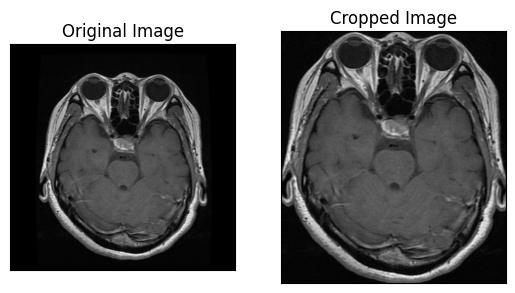

In [4]:
ex_img = cv2.imread('Training_data\yes\Train_Tumor (1).jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)
        
    # Shuffle the data
    X, y = shuffle(X, y)
        
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    return X, y

In [11]:
augmented_path = 'Training_data/'

augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

: 

In [7]:
def plot_sample_images(X, y, n=50):
   
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

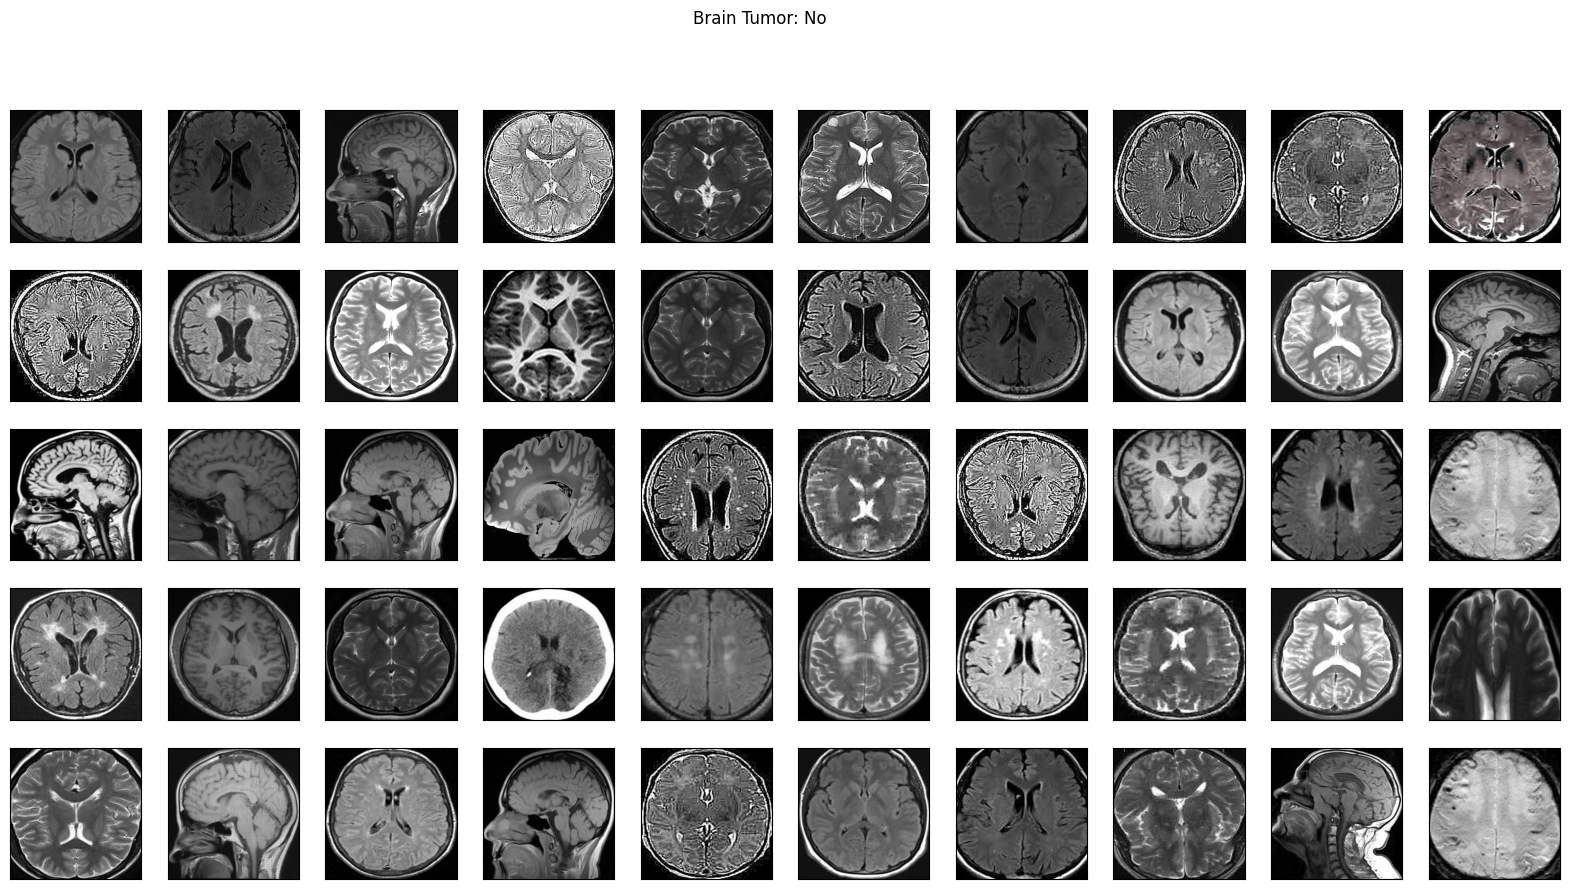

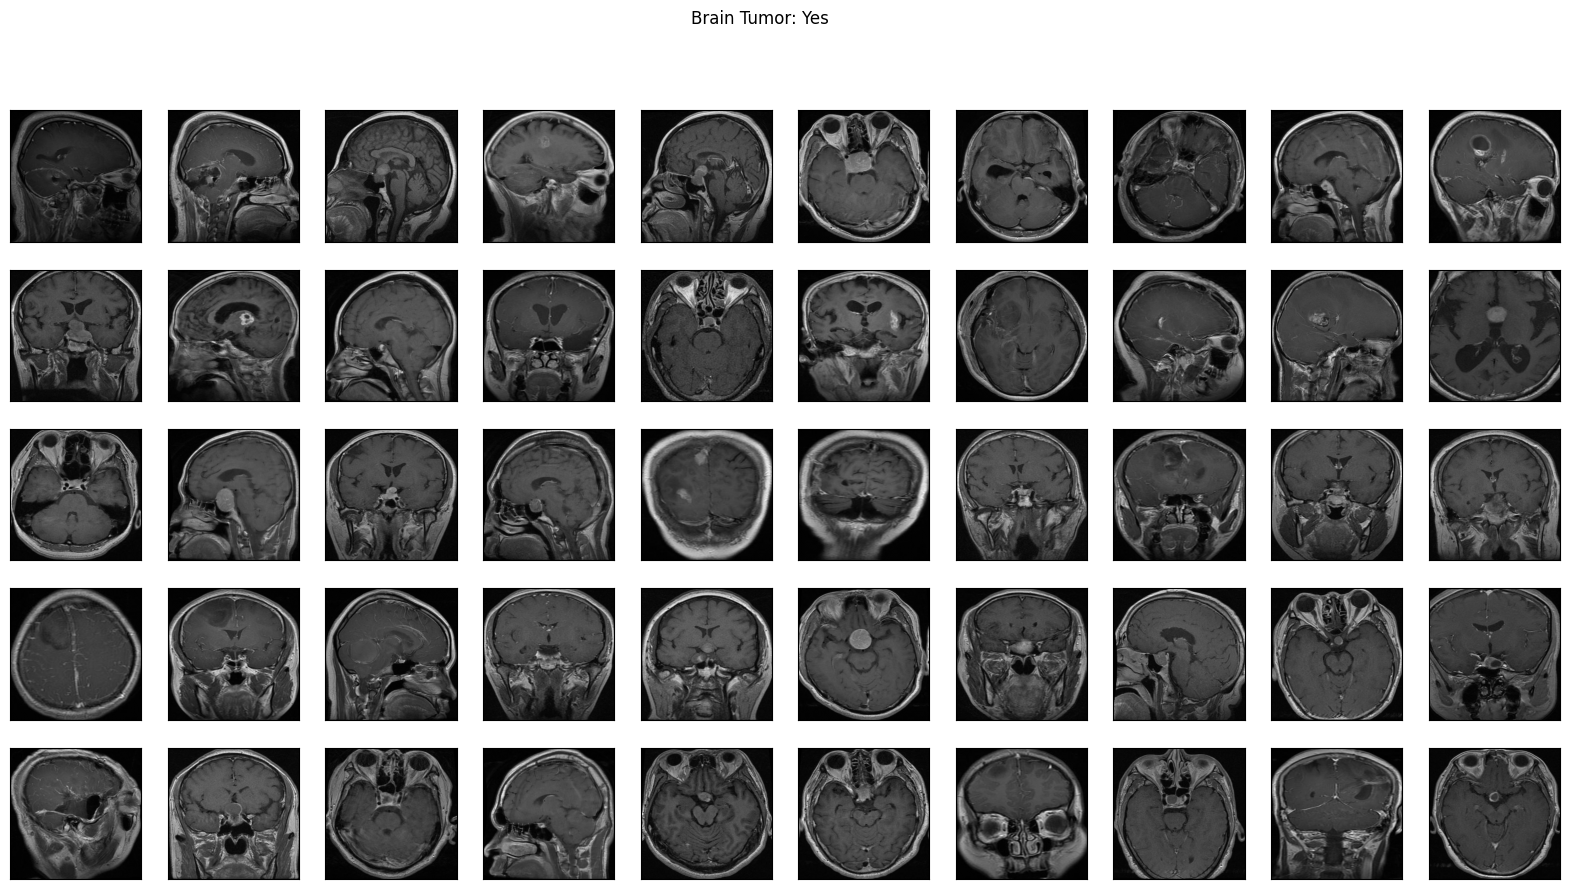

In [7]:
plot_sample_images(X, y)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of validation samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Number of training samples: 2097
Number of validation samples: 449
Number of test samples: 450
X_train shape: (2097, 240, 240, 3), y_train shape: (2097, 1)
X_val shape: (449, 240, 240, 3), y_val shape: (449, 1)
X_test shape: (450, 240, 240, 3), y_test shape: (450, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [13]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# Define the file path for saving the model
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras"

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    filepath="models/{}".format(filepath), 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [20]:
# Define the file path for saving the model
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    filepath="models/{}".format(filepath), 
    monitor='val_accuracy',  # Use 'val_accuracy' instead of 'val_acc'
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Training the model
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=1, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7888 - loss: 0.5913
Epoch 1: val_accuracy improved from -inf to 0.58797, saving model to models/cnn-parameters-improvement-01-0.59.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7902 - loss: 0.5871 - val_accuracy: 0.5880 - val_loss: 0.5102
Elapsed time: 0:2:10.0


In [21]:
history = model.history.history

In [22]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [23]:
print(history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [30]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Access the metrics directly as history is already a dictionary
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()




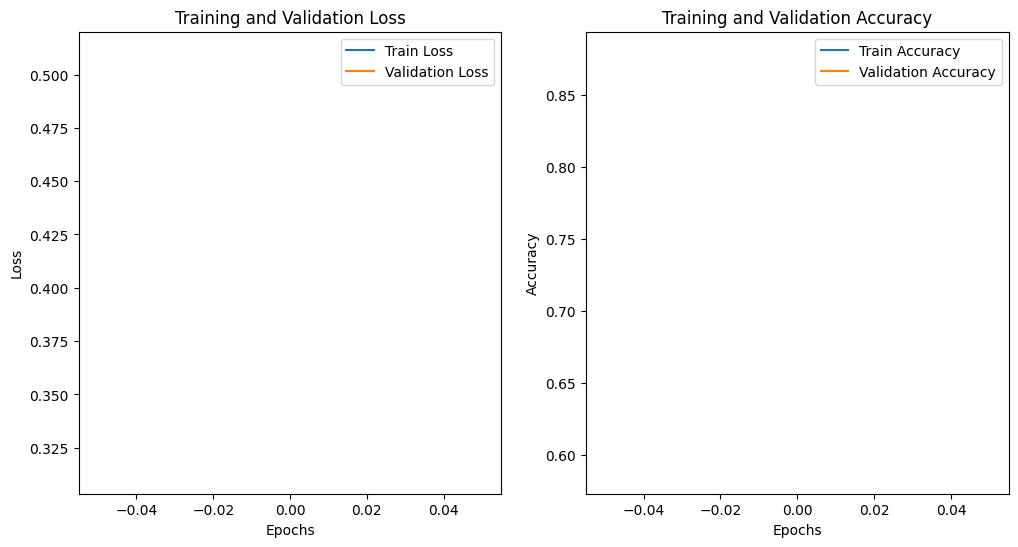

In [31]:
# Call the function with the dictionary
plot_metrics(history)

In [8]:
best_model = load_model(filepath='best_model.keras')

In [9]:
best_model.metrics_names

['loss', 'compile_metrics']

In [10]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

NameError: name 'X_test' is not defined

In [35]:
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9929 - loss: 0.0355


In [36]:
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

Validation Accuracy: 0.9888641238212585
Validation Loss: 0.05568317323923111


In [37]:
print (f"Test Accuracy = {acc}")
print (f"Test Loss = {loss}")

Test Accuracy = 0.9933333396911621
Test Loss = 0.05270162224769592


In [38]:
y_test_prob = best_model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step


In [39]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9934065934065934


In [40]:
y_val_prob = best_model.predict(X_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step


In [41]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9885057471264368


In [42]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [43]:
# the whole data
data_percentage(y)

Number of examples: 2996
Percentage of positive examples: 50.0%, number of pos examples: 1498
Percentage of negative examples: 50.0%, number of neg examples: 1498


In [44]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 2097
Percentage of positive examples: 50.35765379113018%, number of pos examples: 1056
Percentage of negative examples: 49.64234620886982%, number of neg examples: 1041
Validation Data:
Number of examples: 449
Percentage of positive examples: 47.88418708240535%, number of pos examples: 215
Percentage of negative examples: 52.11581291759465%, number of neg examples: 234
Testing Data:
Number of examples: 450
Percentage of positive examples: 50.44444444444444%, number of pos examples: 227
Percentage of negative examples: 49.55555555555556%, number of neg examples: 223


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.00011918]]


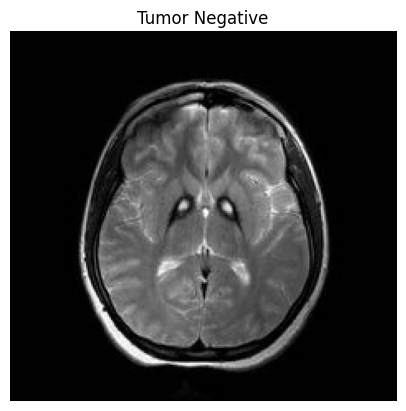

Prediction: Tumor Negative


In [45]:
image_path = 'Training_data/no/Train_No-tumor (99).jpg'

# Read the image
image = cv2.imread(image_path)

# Crop the brain contour (if applicable)
image = crop_brain_contour(image, plot=False)

# Resize the image to the required input size for the model (240x240)
image = cv2.resize(image, (240, 240))

# Normalize the image
image = image / 255.0

# Expand dimensions to match the model's input shape (1, 240, 240, 3)
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = best_model.predict(image)

print(prediction)
# Interpret the prediction
if prediction > 0.5:
    result = "Tumor Positive"
else:
    result = "Tumor Negative"

# Convert the image to RGB for correct display
img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Display the image with the result
plt.imshow(img_rgb)
plt.title(result)
plt.axis('off')
plt.show()

print(f"Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.99889547]]


<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_15128\2508668631.py:1: SyntaxWarning: invalid escape sequence '\y'
  image_path = 'Training_data\yes\Train_Tumor (99).jpg'


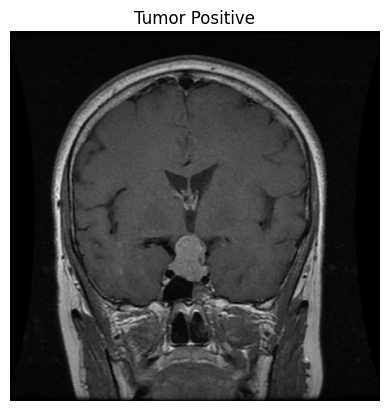

Prediction: Tumor Positive


In [46]:
image_path = 'Training_data\yes\Train_Tumor (99).jpg'

# Read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Image not found at {image_path}")
else:
    # Crop the brain contour (if applicable)
    image = crop_brain_contour(image, plot=False)

    # Resize the image to the required input size for the model (240x240)
    image = cv2.resize(image, (240, 240))

    # Normalize the image
    image = image / 255.0

    # Expand dimensions to match the model's input shape (1, 240, 240, 3)
    image = np.expand_dims(image, axis=0)

    # Make the prediction
    prediction = best_model.predict(image)
    print(prediction)

    # Interpret the prediction
    if prediction > 0.5:
        result = "Tumor Positive"
    else:
        result = "Tumor Negative"

    # Convert the image to RGB for correct display
    img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Display the image with the result
    plt.imshow(img_rgb)
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {result}")


In [47]:
from flask import Flask, request, render_template, redirect, url_for
import numpy as np
import cv2
from tensorflow.keras.models import load_model
#from crop_brain_contour import crop_brain_contour  # Assuming you already have this function

app = Flask(__name__)

# Load the pre-trained model
model = load_model('models/cnn-parameters-improvement-14-0.99.keras')

def prepare_image(image_path):
    # Read the image, crop, resize, normalize, and expand dimensions
    image = cv2.imread(image_path)
    image = crop_brain_contour(image, plot=False)
    image = cv2.resize(image, (240, 240), interpolation=cv2.INTER_CUBIC)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

@app.route('/')
def index():
    return render_template('./index.html')



@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return redirect(request.url)

    file = request.files['image']
    if file.filename == '':
        return redirect(request.url)

    # Save the uploaded file temporarily in the static directory
    image_path = f'static/uploaded_image.jpg'
    file.save(image_path)

    # Prepare the image and make the prediction
    image = prepare_image(image_path)
    prediction = model.predict(image)

    # Interpret the result
    result = "Tumor Positive" if prediction > 0.5 else "Tumor Negative"
    prediction_value = float(prediction[0][0])  # Extract the prediction value

    # Pass the result, prediction value, and image path to the template
    return render_template(
        'result.html', 
        result=result, 
        prediction_value=prediction_value, 
        image_path='uploaded_image.jpg'
    )


if __name__ == '__main__':
    app.run(debug=False)  # Set debug=False


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Jan/2025 12:53:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:53:19] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:53:19] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


127.0.0.1 - - [01/Jan/2025 12:53:27] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:53:27] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:53:27] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


127.0.0.1 - - [01/Jan/2025 12:53:38] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:53:38] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:53:38] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


127.0.0.1 - - [01/Jan/2025 12:53:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:53:47] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:53:47] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


127.0.0.1 - - [01/Jan/2025 12:53:56] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:53:56] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:53:56] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


127.0.0.1 - - [01/Jan/2025 12:54:07] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:54:07] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:54:07] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


127.0.0.1 - - [01/Jan/2025 12:54:18] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:54:18] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:54:18] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


127.0.0.1 - - [01/Jan/2025 12:54:26] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jan/2025 12:54:26] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Jan/2025 12:54:26] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
unseen_data_generator = datagen.flow_from_directory(
    'Unseen_data',
    target_size=(240, 240),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 112 images belonging to 2 classes.


In [51]:
loss, accuracy = best_model.evaluate(unseen_data_generator, verbose=1)

C:\Users\PMLS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 0.3781 - loss: 3.3603


In [52]:
print(f"Loss on unseen data: {loss}")
print(f"Accuracy on unseen data: {accuracy}")

Loss on unseen data: 2.9329187870025635
Accuracy on unseen data: 0.4375


In [53]:
from sklearn.metrics import classification_report

# Assuming you have true labels (y_true) and predictions (y_pred)
y_true = unseen_data_generator.classes  # True labels of unseen data
y_pred = model.predict(unseen_data_generator)  # Predicted probabilities
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Get the classification report
report = classification_report(y_true, y_pred)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step
              precision    recall  f1-score   support

           0       0.40      0.32      0.36        56
           1       0.43      0.52      0.47        56

    accuracy                           0.42       112
   macro avg       0.42      0.42      0.41       112
weighted avg       0.42      0.42      0.41       112

